### Importing the necessary libraries
1. gdown for downloading the dataset directly from drive.
2. sklearn.model_selection for splitting the data.
3. scipy for calculating mode.

In [1]:
import numpy as np
import pandas as pd
import gdown
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats

## Q1: Training an Artificial Neural Network

In [2]:
data_q1_id = "15AADwQUAu0yzpQhQnbCuEpfxNw__w6Mx"
data_q1_url = f"https://drive.google.com/uc?id={data_q1_id}"

gdown.download(data_q1_url, "df_data_q1.csv", quiet=False)

df_data_q1 = pd.read_csv("df_data_q1.csv")

Downloading...
From: https://drive.google.com/uc?id=15AADwQUAu0yzpQhQnbCuEpfxNw__w6Mx
To: /content/df_data_q1.csv
100%|██████████| 8.47k/8.47k [00:00<00:00, 12.1MB/s]


### Dataset Preparation

In [3]:
training_x1 = df_data_q1["x1"].to_numpy()
training_x2 = df_data_q1["x2"].to_numpy()
training_y = df_data_q1["y"].to_numpy()

N = len(training_x1)

training_x = np.array([[x1,x2,1] for x1,x2 in zip(training_x1,training_x2)])

* Setting seed
* Defining ```sigmoid``` and ```grad_sigmoid``` function.


In [4]:
np.random.seed(123)

def sigmoid(x):
  return 1 / (1 + np.exp(-x)) #sigmoid

def grad_sigmoid(x):
  return ((sigmoid(x))*(1-sigmoid(x))) #derivative of sigmoid

* Initalizing $w_1$ and $w_2$ randomly with appropriate dimensions.

In [5]:
w1 = np.random.uniform(-1, 1, (3,3))
w2 = np.random.uniform(-1, 1, (4,1))

learning_rate, max_epochs = 0.05, 100 #constants
w1

array([[ 0.39293837, -0.42772133, -0.54629709],
       [ 0.10262954,  0.43893794, -0.15378708],
       [ 0.9615284 ,  0.36965948, -0.0381362 ]])

* Setting ```X``` = ```training_x``` .
* Defining function ```append_ones``` which takes a matrix as input and append 1 in the last column.
* Defining function training_neural_networks:
  1. Takes ```X```, training output, weights, learning rate and max epochs as parameters.
  2. Does the necessary calculations (calculations regrading gradient of loss with respect to w1 and w2 is in the pdf 'AI1013_calculations.pdf').
  3. At each epoch it appends the training loss in an array ```training_error```.
  4. Function returns the training array as output.

* Plotting training loss over epochs: Loss decreases consistently till 100 epochs.


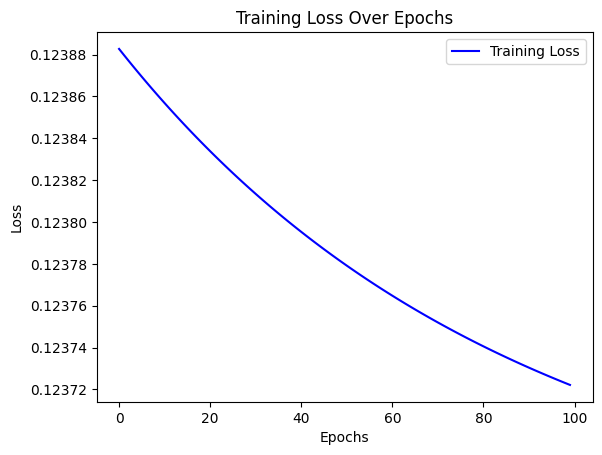

In [6]:
X = training_x

def append_ones(matrix):
    ones_column = np.ones((matrix.shape[0], 1))
    return np.concatenate((matrix, ones_column), axis=1)

def training_neuralnetwork(X, training_y, w1, w2, learning_rate, max_epochs):
  training_error = []

  for epoch in range(max_epochs):
    # Forward propagation
    H = X @ w1
    Z = sigmoid(H)
    Z = append_ones(Z)
    O = Z @ w2
    y_predicted = sigmoid(O)

    # Calculate loss
    y_predicted = y_predicted.reshape(-1,1)
    training_y = training_y.reshape(-1,1)
    y = y_predicted - training_y
    loss = (np.sum((y)**2))/(2*N)
    training_error.append(loss)

    # Backpropagation
    delta2 = (y) * grad_sigmoid(y_predicted)
    gradient2 = np.dot(Z.T, delta2)

    delta1 = np.dot(delta2, w2.T) * grad_sigmoid(Z)
    delta1 = delta1[:, :-1]
    gradient1 = np.dot(X.T, delta1)

    #updating weights
    w2 -= (learning_rate/N) * gradient2
    w1 -= (learning_rate/N) * gradient1

  return training_error


training_error = training_neuralnetwork(X, training_y, w1, w2, 0.05, 100)


plt.plot(list(range(len(training_error))), training_error, label="Training Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()



## Q2: Classification using the k‐Nearest Neighbors Technique

### Importing the dataset


In [7]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
abalone = pd.read_csv(url, header=None)

### Setting appropriate Column names

In [8]:
abalone.columns = ["Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings"]
print(abalone.head())
print(abalone.shape)

  Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7  
(4177, 9)


### Data Processing:
* ```X``` are the values in the table except 'Rings' and 'Sex'
* ```Y``` is the number of rings(to determine abalone's age)
* Splitting data into train and test data sets.

In [9]:
X = abalone.drop(['Rings', 'Sex'], axis = 1).values
y = abalone['Rings'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=333)

### Implementing K-nearest neighbours:
* ```distances``` store the distance of new data point from training data points.
* ```nearest_indices``` store the index of smallest k distances.
* ```k_rings``` store the respective number of rings corresponding to ```nearest_indices```
* ```modes``` is an array of all the modes of the array ```k_rings```.
* ```mode``` is one random mode.
* ```predicted_results``` is an array which stores the predicted output.
* Calculating mse by $$MSE = \frac{1}{M}∑_{j = 0}^{M-1} (y_{predicted}[j] - y_{actual}[j])^2$$

In [10]:
from statistics import multimode

def knn(k, X_train, X_test, y_train, y_test):
  predicted_results = []
  for i in range(len(X_test)):
    distances = np.linalg.norm(X_train - X_test[i], axis=1)
    nearest_indices = np.argsort(distances)[:k]
    k_rings = y_train[nearest_indices]
    modes = multimode(k_rings)
    np.random.seed(123)
    mode = np.random.choice(modes)
    predicted_results.append(mode)

  return np.array(predicted_results)

def calculate_mse(y_pred, y_test):
  mse = np.mean((y_pred - y_test) ** 2)
  return mse

#mse for k = 3
y_pred = knn(3, X_train, X_test, y_train, y_test)
mse = calculate_mse(y_pred, y_test)
print("Mean Squared Error for k =3 :", mse)

Mean Squared Error for k =3 : 7.515948963317384


### Storing mse values for k =1 to 50 in an array ```mse_values```

In [11]:
mse_values = []
for i in range(50):
  y_pred = knn(i+1, X_train, X_test, y_train, y_test)
  mse = calculate_mse(y_pred, y_test)
  mse_values.append(mse)

### Finding elbow point
1. To calculate elbow point we will use the idea that at elbow point curve bends the most.
2. The curve bends the most where the second derivative of function is maximum.
3. We will approximate, $$f^{'}(x) = f(x+1) - f(x) $$
4. By this we will find first and second derivative and then corresponding elbow point.

In [25]:
k_values = list(range(1, 51))
first_derivative = np.diff(mse_values)
second_derivative = np.diff(first_derivative)

elbow_k = k_values[np.argmax(second_derivative) + 1]

print(f"Elbow Point: {elbow_k}")
elbow_mse = mse_values[elbow_k - 1]
minimum_mse = min(mse_values)
optimal_k = k_values[np.argmin(mse_values)]

Elbow Point: 3


### Plotting using matplotlib

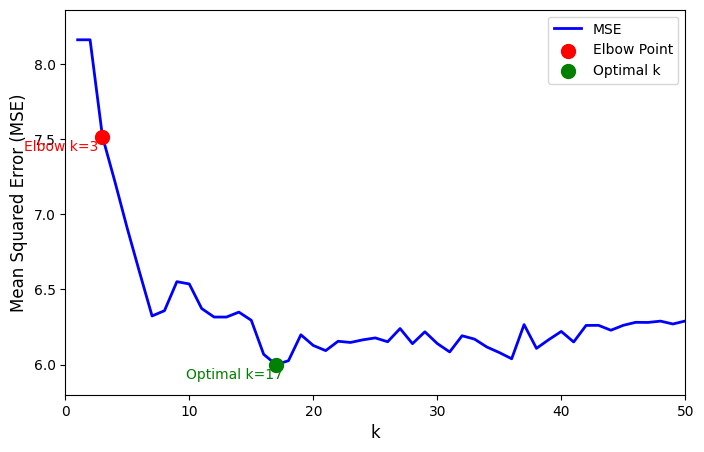

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, mse_values, color='blue', linestyle='-', linewidth=2, label="MSE")
plt.scatter(elbow_k, elbow_mse, color='red', s=100, zorder=3, label="Elbow Point")
plt.scatter(optimal_k, minimum_mse, color='green', s=100, zorder=3, label="Optimal k")
plt.annotate(f'Elbow k={elbow_k}', (elbow_k, elbow_mse), textcoords="offset points",
             xytext=(-30, -10), ha='center', fontsize=10, color='red')
plt.annotate(f'Optimal k={optimal_k}', (optimal_k, minimum_mse), textcoords="offset points",
             xytext=(-30, -10), ha='center', fontsize=10, color='green')

# Formatting
plt.xlabel("k", fontsize=12)
plt.ylabel("Mean Squared Error (MSE)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(0, 50)
plt.ylim(min(mse_values) - 0.2, max(mse_values) + 0.2)
plt.legend()
plt.show()